<a href="https://colab.research.google.com/github/MohamedMousa2000/CNN_For_MNIST/blob/main/MNIST_Classification_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import albumentations as albu
from skimage.transform import resize
from tensorflow import keras as ks
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam, SGD
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
print(tf.__version__)

2.9.2


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.503039010000009
GPU (s):
0.04005127799999286
GPU speedup over CPU: 87x


In [ ]:
batch_size = 50
img_width, img_height, img_num_channels = 28, 28, 1
loss_function = 'sparse_categorical_crossentropy'
no_classes = 10
no_epochs = 20
optimizer = 'adam'
validation_split = 0.2
verbosity = 1

In [ ]:
MNIST = ks.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = MNIST.load_data()

In [ ]:
print(X_train.shape)
print(Y_train.shape)

(60000, 28, 28)
(60000,)


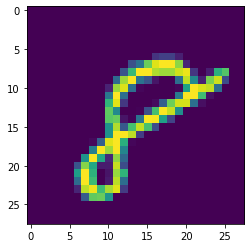

In [ ]:
plt.imshow(X_train[59999])

In [ ]:
X_train = X_train/255.0
X_test = X_test/255.0
#Y_train = tf.keras.utils.to_categorical(Y_train, no_classes)
#Y_test = tf.keras.utils.to_categorical(Y_test, no_classes)
Y_train.shape

(60000,)

In [ ]:
Y_train.shape

(60000,)

In [ ]:
CNN_Model = ks.models.Sequential()
CNN_Model.add(ks.layers.Conv2D(16,(3,3),activation='relu',input_shape=(28,28,1),data_format="channels_last",padding='same',name='First_Layer_CONV'))
CNN_Model.add(ks.layers.Conv2D(16,(3,3),activation='relu',name='Second_Layer_CONV'))

In [ ]:
CNN_Model.add(ks.layers.MaxPool2D((2,2),name='1st_Max_Pooling'))
#CNN_Model.add(ks.layers.Dropout(0.1))

In [ ]:
CNN_Model.add(ks.layers.Conv2D(32,(3,3),activation='relu',padding='same',name='Third_Layer_CONV'))
CNN_Model.add(ks.layers.Conv2D(32,(3,3),activation='relu',name='Forth_Layer_CONV'))

In [ ]:
CNN_Model.add(ks.layers.MaxPool2D((2,2),name='2nd_Max_Pooling'))
#CNN_Model.add(ks.layers.Dropout(0.25))

In [ ]:
CNN_Model.add(ks.layers.Conv2D(64,(3,3),activation='relu',padding='same',name='Fifth_Layer_CONV'))
CNN_Model.add(ks.layers.Conv2D(64,(3,3),activation='relu',padding='same',name='Sixth_Layer_CONV'))

In [ ]:
CNN_Model.add(ks.layers.Flatten(name='FC'))
CNN_Model.add(ks.layers.Dense(512,activation='relu',name='First_Hidden_Layer'))
#CNN_Model.add(ks.layers.Dropout(0.5))
CNN_Model.add(ks.layers.BatchNormalization())
CNN_Model.add(ks.layers.Dense(256,activation='relu',name='Second_Hidden_Layer'))
CNN_Model.add(ks.layers.BatchNormalization())
CNN_Model.add(ks.layers.Dense(128,activation='relu',name='Third_Hidden_Layer'))
CNN_Model.add(ks.layers.Dense(100,activation='softmax',name='Output_Layer'))

In [ ]:
CNN_Model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 First_Layer_CONV (Conv2D)   (None, 28, 28, 16)        160       
                                                                 
 Second_Layer_CONV (Conv2D)  (None, 26, 26, 16)        2320      
                                                                 
 1st_Max_Pooling (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 Third_Layer_CONV (Conv2D)   (None, 13, 13, 32)        4640      
                                                                 
 Forth_Layer_CONV (Conv2D)   (None, 11, 11, 32)        9248      
                                                                 
 2nd_Max_Pooling (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                  

In [ ]:
#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)


In [ ]:
CNN_Model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
History_Of_Training = CNN_Model.fit(X_train,Y_train,epochs=no_epochs,batch_size=batch_size,verbose=verbosity,validation_split=validation_split,callbacks = [early_stop, rlrop])

Epoch 1/20
960/960 [==============================] - 7s 6ms/step - loss: 0.1439 - accuracy: 0.9592 - val_loss: 0.0645 - val_accuracy: 0.9815 - lr: 0.0010
Epoch 2/20
960/960 [==============================] - 6s 6ms/step - loss: 0.0632 - accuracy: 0.9810 - val_loss: 0.0842 - val_accuracy: 0.9736 - lr: 0.0010
Epoch 3/20
960/960 [==============================] - 7s 7ms/step - loss: 0.0509 - accuracy: 0.9836 - val_loss: 0.0990 - val_accuracy: 0.9728 - lr: 0.0010
Epoch 4/20
960/960 [==============================] - 7s 7ms/step - loss: 0.0412 - accuracy: 0.9878 - val_loss: 0.1270 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 5/20
960/960 [==============================] - 6s 6ms/step - loss: 0.0380 - accuracy: 0.9884 - val_loss: 0.0460 - val_accuracy: 0.9874 - lr: 0.0010
Epoch 6/20
960/960 [==============================] - 6s 6ms/step - loss: 0.0308 - accuracy: 0.9900 - val_loss: 0.0472 - val_accuracy: 0.9876 - lr: 0.0010
Epoch 7/20
960/960 [==============================] - 6s 6ms/step - lo

In [ ]:
Training_Loss, Training_Accuracy = CNN_Model.evaluate(X_train,Y_train)
print(f"Accuracy = {round(float(Training_Accuracy),2)}")

1875/1875 [==============================] - 7s 3ms/step - loss: 0.0081 - accuracy: 0.9983
Accuracy = 1.0


In [ ]:
Test_Loss, Test_Accuracy = CNN_Model.evaluate(X_test,Y_test)
print(f"Accuracy = {round(float(Test_Accuracy),2)}")

313/313 [==============================] - 1s 4ms/step - loss: 0.0269 - accuracy: 0.9939
Accuracy = 0.99


Test loss: 0.02685130387544632 / Test accuracy: 0.9939000010490417


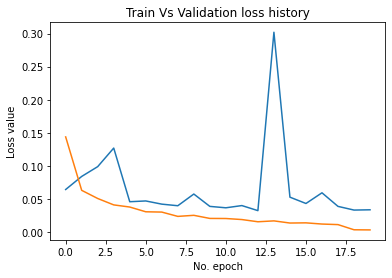

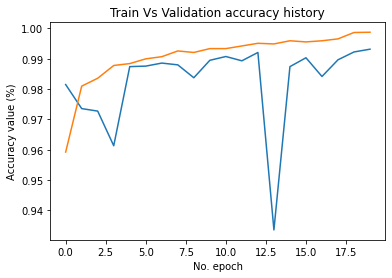

In [ ]:
score = CNN_Model.evaluate(X_test, Y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

# Visualize history
# Plot history: Loss
plt.plot(History_Of_Training.history['val_loss'])
plt.plot(History_Of_Training.history['loss'])
plt.title('Train Vs Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.plot(History_Of_Training.history['val_accuracy'])
plt.plot(History_Of_Training.history['accuracy'])
plt.title('Train Vs Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()